In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Create graph with navigation information

In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4491575,0],
    [0.89831528412,0],
    [1.34747292618,0],
    [1.79663056824,0],
    [2.2457882103,0],
    [2.69494585236,0],
    [3.14410349442,0],
    [3.59326113648,0],
    [4.04241877854,0],
    [4.4915764206,0],
    [4.94073406266,0],    
    [5.38989170472,0], 
] 


# for each edge (between above coordinates) specify the depth (m)
depths = [
           4.5, 4.5, 4.5, 4.5, 4.5, 4.5,
           4.5, 4.5, 4.5, 4.5, 4.5, 4.5,
         ] # [m]

current_speeds = [
                    -1* 0.2777,  -1* 0.2777, -1* 0.2777, -1* 0.2777, -1* 0.2777, -1* 0.2777,
                        -1* 0.2777,  -1* 0.2777, -1* 0.2777, -1* 0.2777, -1* 0.2777, -1* 0.2777, 
                ]  # [m/s]

V_g_profile_up = [
                    3.6, 3.6, 3.6, 3.6, 3.6,3.6,   
                    3.6, 3.6, 3.6, 3.6, 3.6,3.6, 
                ] # [m/s] for upstream, 3.6 m/s = 13 km/h

V_g_profile_down = [
                     4.72, 4.72, 4.72, 4.72, 4.72, 4.72, 
                     4.72, 4.72, 4.72, 4.72, 4.72, 4.72,                      
                    ] # [m/s] for downstream, 4.72 m/s = 17 km/h


# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

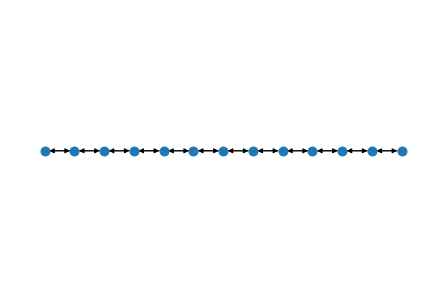

In [4]:
# show graph
nx.draw(FG, positions, node_size=80)

plt.show()

### Define the path 1 on the graph for energy use simulation

In [5]:
path_down = nx.dijkstra_path(FG, nodes[12].name, nodes[0].name)

### Create vessel sailing on path 1 - add VesselProperties and ConsumesEnergy mixins

In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

vessels sailing on path up include 3 vessel types sailing upstream loaded 

In [7]:
# Create a dict with all important settings

data_vessel_M12_down_loaded = {
    "env": None,
    "name": 'MCV135_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 17,
    "L": 135,
    "T": 3,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":3000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.85, 
    "C_year": 2000, # the engine construction year is only used for diesel use and emissions quantification
}             



In [8]:
# Create a dict with all important settings

data_vessel_M8_down_loaded = {
    "env": None,
    "name": 'MCV110_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 2.5,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.85, 
    "C_year": 2000, # the engine construction year is only used for diesel use and emissions quantification
}             



In [9]:
# Create a dict with all important settings

data_vessel_M6_down_loaded = {
    "env": None,
    "name": 'MCV85_9_5_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 2000, # the engine construction year is only used for diesel use and emissions quantification
}             



### Define simulation

define basic simulation for vessel moving and consuming energy

In [10]:
def run_simulation(path,**data_vessel):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    # vessel.V_g_ave = V_g_ave
    # vessel.sailing_upstream = sailing_upstream
    # vessel.P_tot_given = P_tot_given
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

define specific vessel simulation with vessel type and number of trips

In [11]:
def get_energy(nr_trips, path,**data_vessel):
    vessel = run_simulation(path,**data_vessel)
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel=vessel)
    energycalculation.calculate_energy_consumption()
    
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    
    selected = ['distance','total_H2_300bar_PEMFC_40ft_containers']
    df_energy = df[selected]
    df_energy['distance_km_cum']=df_energy['distance'].cumsum()/1000

    df_energy['total_H2_300bar_PEMFC_40ft_containers_cum'] = df_energy['total_H2_300bar_PEMFC_40ft_containers'].cumsum()
    df_energy['total_trips_H2_300bar_PEMFC_40ft_containers'] = df_energy['total_H2_300bar_PEMFC_40ft_containers']*nr_trips
    df_energy['total_trips_H2_300bar_PEMFC_40ft_containers_cum'] = df_energy['total_trips_H2_300bar_PEMFC_40ft_containers'].cumsum()
    return df_energy

In [12]:
energy_M12_down_loaded = get_energy(450,path_down,**data_vessel_M12_down_loaded)
# pd.options.display.max_columns = None
energy_M12_down_loaded

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_18500\3681337092.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_18500\3681337092.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_18500

,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum,total_trips_H2_300bar_PEMFC_40ft_containers,total_trips_H2_300bar_PEMFC_40ft_containers_cum
0,50000.000000,0.514302,50.000000,0.514302,231.435731,231.435731
1,50000.000000,0.514302,100.000000,1.028603,231.435731,462.871461
2,50000.000000,0.514302,150.000000,1.542905,231.435731,694.307192
3,50000.000000,0.514302,200.000000,2.057206,231.435731,925.742923
4,50000.000000,0.514302,250.000000,2.571508,231.435731,1157.178653
5,50000.000000,0.514302,300.000000,3.085810,231.435731,1388.614384
6,50000.000000,0.514302,350.000000,3.600111,231.435731,1620.050115
7,50000.000000,0.514302,400.000000,4.114413,231.435731,1851.485845
8,50000.000000,0.514302,450.000000,4.628715,231.435731,2082.921576
9,50000.000000,0.514302,500.000000,5.143016,231.435731,2314.357307


In [13]:
energy_M8_down_loaded = get_energy(450,path_down,**data_vessel_M8_down_loaded)
# pd.options.display.max_columns = None
energy_M8_down_loaded

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_18500\3681337092.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_18500\3681337092.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_18500

,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum,total_trips_H2_300bar_PEMFC_40ft_containers,total_trips_H2_300bar_PEMFC_40ft_containers_cum
0,50000.000000,0.242643,50.000000,0.242643,109.189400,109.189400
1,50000.000000,0.242643,100.000000,0.485286,109.189400,218.378800
2,50000.000000,0.242643,150.000000,0.727929,109.189400,327.568199
3,50000.000000,0.242643,200.000000,0.970572,109.189400,436.757599
4,50000.000000,0.242643,250.000000,1.213216,109.189400,545.946999
5,50000.000000,0.242643,300.000000,1.455859,109.189400,655.136399
6,50000.000000,0.242643,350.000000,1.698502,109.189400,764.325798
7,50000.000000,0.242643,400.000000,1.941145,109.189400,873.515198
8,50000.000000,0.242643,450.000000,2.183788,109.189400,982.704598
9,50000.000000,0.242643,500.000000,2.426431,109.189400,1091.893998


In [14]:
energy_M6_down_loaded = get_energy(450,path_down,**data_vessel_M6_down_loaded)
# pd.options.display.max_columns = None
energy_M6_down_loaded

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_18500\3681337092.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_18500\3681337092.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_18500

,distance,total_H2_300bar_PEMFC_40ft_containers,distance_km_cum,total_H2_300bar_PEMFC_40ft_containers_cum,total_trips_H2_300bar_PEMFC_40ft_containers,total_trips_H2_300bar_PEMFC_40ft_containers_cum
0,50000.000000,0.158404,50.000000,0.158404,71.281708,71.281708
1,50000.000000,0.158404,100.000000,0.316808,71.281708,142.563415
2,50000.000000,0.158404,150.000000,0.475211,71.281708,213.845123
3,50000.000000,0.158404,200.000000,0.633615,71.281708,285.126831
4,50000.000000,0.158404,250.000000,0.792019,71.281708,356.408538
5,50000.000000,0.158404,300.000000,0.950423,71.281708,427.690246
6,50000.000000,0.158404,350.000000,1.108827,71.281708,498.971954
7,50000.000000,0.158404,400.000000,1.267230,71.281708,570.253661
8,50000.000000,0.158404,450.000000,1.425634,71.281708,641.535369
9,50000.000000,0.158404,500.000000,1.584038,71.281708,712.817077
